In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
import nltk
#import spacy
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS #get_ipython().system('pip install wordcloud')
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
tweet_input = pd.read_csv("covid19_tweets.csv")
pd.options.mode.chained_assignment = None 

### Filter tweet by hashtag count>100

In [3]:
tweet= tweet_input['text']
def convert(lst):
    return ([i for item in lst for i in item.split()])
panda_df = pd.DataFrame(data =tweet_input, columns = ["text","hashtags"])
panda_df=panda_df[panda_df['hashtags'].notnull()]
df = pd.DataFrame(convert(panda_df['hashtags']))
df=df.replace(',','', regex=True)
df=df.replace("]",'', regex=True)
df=df.replace('\'','', regex=True)
df=df.replace('\[''', '', regex=True)
df.columns=['Words']
s=df.value_counts()
Words=pd.DataFrame(s.nlargest(155))
modified = Words.reset_index()
modified.columns=['Words',"Counts"]
#print(modified) ## Mention count above 100
selection = modified['Words'].tolist()
filtered_tweet=tweet_input[tweet_input['hashtags'].notnull()]
## Hashtags which contains these top 100 words
mask = filtered_tweet.hashtags.apply(lambda x: any(item for item in selection if item in x))
filtered_tweet=filtered_tweet[mask]

In [4]:
data = filtered_tweet[['user_name','date','text','hashtags']]

In [5]:
import re      # Import REGEX
def remove_mentions(text):
    text = re.sub("@[A-Za-z0-9_]+","", text)
    return text

data['text'] =data.apply(lambda row: remove_mentions(row['text']), axis=1)
import re, string, unicodedata 
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

data['text'] =data.apply(lambda row: remove_non_ascii(row['text']), axis=1)

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # prevent showing future warning
tweet= data.loc[:,'text']
##remove website
tweet= tweet.str.replace(r"http\S+", "")
#remove hashtags
tweet = tweet.str.replace(r'#','', regex=True)
##remove punctuation
tweet = tweet.str.replace('[^\w\s]','')
##remove numbers
tweet = tweet.str.replace(r'\d+', '')
##remove underscore
tweet = tweet.str.replace(r"\W+_\W+", '', regex=True)
tweet = tweet.str.replace(r"_", '', regex=True)
##remove brackets
tweet = tweet.str.replace('\[.*?\]', '')
##convert to lower case
tweet= tweet.str.lower()
##drop empty rows
tweet.dropna(inplace=True)
##remove leading and ending white space
tweet = tweet.str.strip()
tweet = tweet.str.replace(r"\n", '', regex=True)
tweet = tweet.str.replace('  ', ' ', regex=True)
data.loc[:,'text'] =tweet

### Sentiment Analyze using NLTK(nlp) 

In [7]:
# ref NLTK sentiment analyse https://www.nltk.org/howto/sentiment.html
#get_ipython().system('pip install vaderSentiment')
sentiment_analyzer = SentimentIntensityAnalyzer()
scores=[]
sentiment_=[]
sentiment_fit_=[]
for i in data['text']:
    sentiment_score = sentiment_analyzer.polarity_scores(i)
    score = sentiment_score['compound']
    scores.append(score)
data=data.assign(sentiment_score = scores)

for i in data['sentiment_score']:
    if i>0:
        sentiment='positive'
        sentiment_fit=1
    elif i==0:
        sentiment='neutral'
        sentiment_fit=0
    else:
        sentiment='negative'
        sentiment_fit=-1
    sentiment_.append(sentiment)
    sentiment_fit_.append(sentiment_fit)
data=data.assign(sentiments=sentiment_)
data=data.assign(sentiment_fit=sentiment_fit_)

### WordCloud

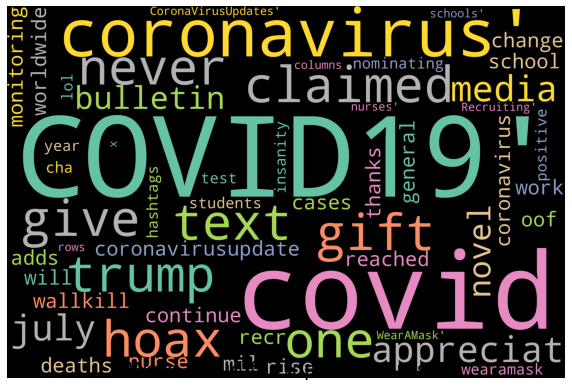

In [8]:
df_wordcloud=data[['text','hashtags']]
word_cloud = WordCloud(background_color='black',colormap='Set2',stopwords=set(STOPWORDS),max_words=100,width = 3000, height = 2000,random_state=1,collocations=False).generate(str(df_wordcloud))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 100 words', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

(array([18468., 18472., 18475., 18479., 18483., 18487., 18491., 18495.,
        18499., 18503.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

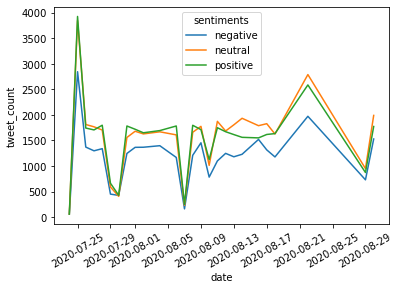

In [9]:
data_agg=data[['date','sentiments','text']]
data_agg['date'] =  pd.to_datetime(data_agg['date']).dt.date 
groups=data_agg.groupby(['date','sentiments'])
data_agg =groups.aggregate('count').reset_index()
data_agg=data_agg.rename(columns={'text': 'tweet_count'})

sns.lineplot(data=data_agg, x="date", y="tweet_count", hue="sentiments")
plt.xticks(rotation = 30)

([<matplotlib.patches.Wedge at 0x7fc814262eb0>,
 [Text(0.7121726395525068, 0.8383377192234734, 'Negative'),
  Text(-1.0566873292628787, 0.3056335848287702, 'Netural'),
  Text(0.45119967458126176, -1.0032042930818048, 'Positive')],
 [Text(0.38845780339227637, 0.45727511957644, '28%'),
  Text(-0.576374906870661, 0.16670922808842006, '36%'),
  Text(0.24610891340796093, -0.5472023416809844, '37%')])

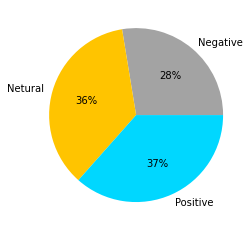

In [10]:
#data_agg.groupby('sentiments').sum() to get the count numbers
data_sum=[30945,40239,40999]
data_lable=['Negative', 'Netural', 'Positive']
colors = sns.color_palette('bright')[7:10]
plt.pie(data_sum,labels = data_lable, colors = colors, autopct='%.0f%%')

## Numerical Summary

In [13]:
## Numerical Summary 
dataa=pd.DataFrame(data[['date','sentiments']])


dataa['date'] = pd.to_datetime(dataa['date'], format='%Y-%m-%d %H:%M:%S',)
dataa['Day'] = [d.date() for d in dataa['date']]
dataa['Time'] = [d.time() for d in dataa['date']]

day_sentiments = dataa.groupby(['Day', 'sentiments']).agg({'Time': 'count'})
day_total = dataa.groupby(['Day']).agg({'Time': 'count'})

pd.set_option("display.max_rows", None, "display.max_columns", None)
day_sentiments.div(day_total, level='Day').round(3) * 100

Time
Day        sentiments      
2020-07-24 negative    33.3
           neutral     33.9
           positive    32.8
2020-07-25 negative    26.8
           neutral     36.2
           positive    37.0
2020-07-26 negative    27.8
           neutral     36.8
           positive    35.4
2020-07-27 negative    27.2
           neutral     37.0
           positive    35.8
2020-07-28 negative    27.7
           neutral     35.2
           positive    37.1
2020-07-29 negative    26.4
           neutral     34.6
           positive    38.9
2020-07-30 negative    33.8
           neutral     32.3
           positive    33.9
2020-07-31 negative    27.2
           neutral     34.0
           positive    38.9
2020-08-01 negative    28.7
           neutral     35.3
           positive    36.1
2020-08-02 negative    29.4
           neutral     35.0
           positive    35.5
2020-08-04 negative    29.4
           neutral     35.1
           positive    35.6
2020-08-06 negative    25.6
           neutral     35.3
           positive    39.1
2020-08-07 negative    25.2
           neutral     35.9
           positive    38.9
2020-08-08 negative    25.9
           neutral     35.6
           positive    38.5
2020-08-09 negative    29.4
           neutral     35.9
           positive    34.6
2020-08-10 negative    26.8
           neutral     34.7
           positive    38.5
2020-08-11 negative    23.3
           neutral     39.7
           positive    37.0
2020-08-12 negative    27.1
           neutral     36.6
           positive    36.3
2020-08-13 negative    25.7
           neutral     39.2
           positive    35.1
2020-08-14 negative    26.0
           neutral     40.9
           positive    33.0
2020-08-16 negative    31.3
           neutral     36.8
           positive    31.9
2020-08-17 negative    27.6
           neutral     38.4
           positive    34.0
2020-08-18 negative    26.5
           neutral     36.6
           positive    36.8
2020-08-22 negative    26.8
           neutral     38.0
           positive    35.2
2020-08-29 negative    28.6
           neutral     37.2
           positive    34.2
2020-08-30 negative    28.9
           neutral     37.6
           positive    33.5

In [11]:
data

,user_name,date,text,hashtags,sentiment_score,sentiments,sentiment_fit
2,Time4fisticuffs,2020-07-25 12:27:14,trump never once claimed covid was a hoax we a...,['COVID19'],-0.2732,negative,-1
3,ethel mertz,2020-07-25 12:27:10,the one gift covid has give me is an appreciat...,['COVID19'],0.7351,positive,1
4,DIPR-J&K,2020-07-25 12:27:08,july media bulletin on novel coronavirusupdate...,"['CoronaVirusUpdates', 'COVID19']",0.3182,positive,1
5,🎹 Franz Schubert,2020-07-25 12:27:06,coronavirus covid deaths continue to rise its ...,"['coronavirus', 'covid19']",-0.4445,negative,-1
6,hr bartender,2020-07-25 12:27:03,how covid will change work in general and recr...,"['COVID19', 'Recruiting']",0.0000,neutral,0
...,...,...,...,...,...,...,...
179101,New Jersey Herald,2020-08-29 19:44:27,wallkill school nurse adds covid monitoring to...,"['nurses', 'COVID19', 'coronavirus', 'schools']",0.0000,neutral,0
179102,Pris,2020-08-29 19:44:23,we have reached mil cases of covid worldwide oof,['covid19'],0.1027,positive,1
179103,AJIMATI AbdulRahman O.,2020-08-29 19:44:21,thanks for nominating me for the wearamask cha...,['WearAMask'],0.4404,positive,1
179104,Jason,2020-08-29 19:44:16,the year of insanity lol covid,['COVID19'],-0.2263,negative,-1


In [15]:
# ref https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#selected=data.iloc[0:10000]
description_list = []
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
for text in data['text']:
    tokenize=nltk.word_tokenize(text)
    words=[]
    for i in tokenize:
        lemma = nltk.WordNetLemmatizer()
        word=lemma.lemmatize(i)
        words.append(word)
    wordss=' '.join(words)
    description_list.append(wordss)
X = vectorizer.fit_transform(description_list).toarray()
y = data['sentiment_fit']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.4, random_state = 42)

NameError: name 'CountVectorizer' is not defined

In [280]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
#Eğitim
nb.fit(X_train,y_train)
#Test
y_pred=nb.predict(X_valid)
print("Navie Bayes algorithm accuracy:",nb.score(X_valid,y_valid)*100)

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_valid)
print("Knn algorithm accuracy=",knn.score(X_valid,y_valid)*100)

model = MultinomialNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
print("multinomial Naive Bayes classifier accuracy=",model.score(X_valid,y_valid)*100)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,random_state=1)
rf_model.fit(X_train, y_train)
print("RandomForest accuracy=",rf_model.score(X_valid,y_valid)*100)

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression algorithm accuracy =",lr.score(X_train, y_train)*100)

from sklearn.neural_network import MLPClassifier
NN_model= MLPClassifier(solver='lbfgs',
    hidden_layer_sizes=(4,3), activation='logistic')
NN_model.fit(X_train, y_train)
print("Multi-layer Perceptron accuracy =",NN_model.score(X_train, y_train)*100)

Navie Bayes algorithm accuracy: 53.400000000000006


In [ ]:
print(data['sentiment_score'].mean(), data['sentiment_score'].std())

In [ ]:
#use boxplot to check outlier
import seaborn as sns
sns.boxplot(x=data['sentiment_score']) 
Q1 = data['sentiment_score'].quantile(0.25)
Q3 = data['sentiment_score'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
#print(Lower_Fence)
print(data.mean(), data.std())

#remove outlier
data=data.loc[data['sentiment_score']>= -0.8725]

In [ ]:
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

def to_timestamp(t):
    return datetime.timestamp(t)
data['timestamp'] = data['date'].apply(to_timestamp)
fit = stats.linregress(data['timestamp'] , data['sentiment_score'])
data['prediction'] = data['timestamp']*fit.slope + fit.intercept
print("fit.slope:",fit.slope)
#fit.slope<0, so the sentimen_score has a slight decrease during the period
print("fit.intercept",fit.intercept)
print("fit.pvalue", fit.pvalue) 
##since p value<0.05, reject H0, the ratings has been changing over time
plt.xticks(rotation = 30)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(data['date'] , data['sentiment_score'], c=data['sentiment_score'], cmap='Spectral')
plt.colorbar()
#plt.plot(data['date'] , data['sentiment_score'] , 'b.' , alpha = 0.5)
plt.plot(data['date'] , data['timestamp']*fit.slope + fit.intercept , 'r-' , linewidth =3)

In [ ]:
residuals=data['sentiment_score']-data['prediction']
plt.hist(residuals)#the requirement of normality can be softened with kind-of-normal data and n>=40

In [ ]:

data_raw = "读入的数据".split('\n') # 按行分隔
data_blue = []
data_red = []
word_count_blue = {}
word_count_red = {}
for line_data in data_raw:
    word_list = line_data.split(" ") # 分隔单词
    if word_list[0] == "BLUE":
        for i in range(1,len(word_list)):
            if not is_excluded(word_list[i]): # 判断是否为停用词
                data_blue.append(word_list[i])
                # 统计单词出现次数
                word_count_blue.setdefault(word_list[i], 0)
                word_count_blue[word_list[i]] += 1
    elif word_list[0] == "RED":